In [27]:
import numpy,sys,matplotlib
import scanpy,velocyto

# 1. Visualization

In [28]:
idata=scanpy.read_csv('/Volumes/omics4tb2/alomana/projects/mscni/data/scanpy/count.file.all.day.clean.csv')

In [29]:
adata=idata.transpose()

scanpy.pp.filter_cells(adata,min_genes=200)
scanpy.pp.filter_genes(adata,min_cells=3)

adata.obs['n_counts'] = adata.X.sum(axis=1)

scanpy.pp.normalize_per_cell(adata, counts_per_cell_after=1e5)
scanpy.pp.log1p(adata)

adata.raw = adata

scanpy.pp.highly_variable_genes(adata,min_mean=0.0125,max_mean=6,min_disp=0.25) # 2,851
adata = adata[:, adata.var['highly_variable']]

scanpy.pp.regress_out(adata,['n_counts'])
scanpy.pp.scale(adata, max_value=10)

# placeholder to regress out cell cycle

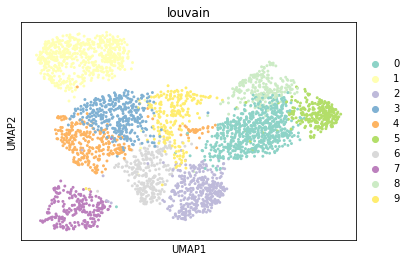

In [30]:
scanpy.tl.pca(adata,svd_solver='arpack')
scanpy.pp.neighbors(adata,n_neighbors=12,n_pcs=50)
scanpy.tl.umap(adata)
scanpy.tl.louvain(adata)
scanpy.pl.umap(adata,color=['louvain'],palette='Set3')

In [31]:
cells_barcodes_per_day={}
barcodes=[]
for element in list(cell_cluster_map.keys()):
    day_label=element.split('.')[1]
    barcode=element.split('_M397')[0]
    barcodes.append(barcode)
    if day_label not in cells_barcodes_per_day:
        cells_barcodes_per_day[day_label]=[barcode]
    else:
        cells_barcodes_per_day[day_label].append(barcode)

print(adata)
print(len(barcodes))
unique_barcodes=list(set(barcodes))
print(len(unique_barcodes))
print(cells_barcodes_per_day.keys())
print(cells_barcodes_per_day['control'][:10])

AnnData object with n_obs × n_vars = 3477 × 2851 
    obs: 'n_genes', 'n_counts', 'louvain'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'neighbors', 'louvain', 'louvain_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
3477
3471
dict_keys(['control', 'day3', 'day6', 'day13', 'day17', 'day24'])
['AAACCTGCAAGAGGCT', 'AAACGGGTCATTCACT', 'AAAGATGAGTCCAGGA', 'AAAGATGCACTTACGA', 'AAAGATGGTGCCTGGT', 'AACCGCGTCTCAAACG', 'AACGTTGAGGGATACC', 'AACGTTGTCTCGTTTA', 'AACTCAGTCACATACG', 'AACTCCCTCTCGCATC']


# 2. Velocity analysis

In [32]:
vlm=velocyto.VelocytoLoom("/Volumes/omics4tb2/alomana/projects/mscni/results/velocyto/combined.loom")

In [33]:
sample_rosetta={}
sample_rosetta['20765_M397_control']='control'
sample_rosetta['21729_day3']='day3'
sample_rosetta['21766_day6']='day6'
sample_rosetta['22077_day13']='day13'
sample_rosetta['22152_day17']='day17'
sample_rosetta['18324_Yapeng_single_cell']='day24'

selected_cells=[]
all_cells=vlm.ca['CellID']

for cellID in all_cells:
    day_label=sample_rosetta[cellID.split(':')[0]]
    barcode=cellID.split(':')[1].replace('x','')
    
    if barcode in cells_barcodes_per_day[day_label]:
        selected_cells.append(cellID)
        
mask=numpy.isin(vlm.ca['CellID'],selected_cells)
print(mask,mask.shape)
    
print(vlm.ca['CellID'].shape[0])
print(vlm.ca['CellID'])
vlm.filter_cells(bool_array=mask)
print(vlm.ca['CellID'].shape[0])

[False  True False ... False False  True] (7396,)
7396
['20765_M397_control:AAGACCTCAGGTCCACx'
 '20765_M397_control:AACTCAGTCACATACGx'
 '20765_M397_control:AAATGCCAGGCTCTTAx' ...
 '18324_Yapeng_single_cell:TTTGTCAAGTATCGAAx'
 '18324_Yapeng_single_cell:TTGGAACCATCGATGTx'
 '18324_Yapeng_single_cell:TTTACTGCAATCAGAAx']
3477


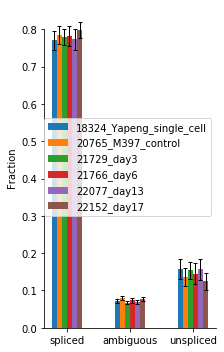

In [34]:
vlm.plot_fractions()

In [35]:
vlm.normalize("S",size=True,log=True)
vlm.normalize("U",size=True,log=False)

In [36]:
vlm.score_detection_levels()
vlm.filter_genes(by_detection_levels=True)

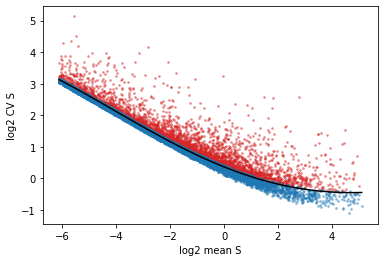

In [37]:
vlm.score_cv_vs_mean(3000, plot=True, max_expr_avg=35)
vlm.filter_genes(by_cv_vs_mean=True)

In [38]:
vlm._normalize_S(relative_size=vlm.S.sum(0),
             target_size=vlm.S.sum(0).mean())
vlm._normalize_U(relative_size=vlm.U.sum(0),
             target_size=vlm.U.sum(0).mean())

In [39]:
number_of_cells=vlm.ca['CellID'].shape[0]
nei=int(0.025*number_of_cells)
print(number_of_cells,nei)

3477 86


In [40]:
vlm.perform_PCA(n_components=50)
vlm.knn_imputation(k=nei,n_pca_dims=50,balanced=True,n_jobs=1)

In [41]:
vlm.fit_gammas()

In [42]:
vlm.predict_U()
vlm.calculate_velocity()
vlm.calculate_shift(assumption="constant_velocity")
vlm.extrapolate_cell_at_t(delta_t=1.)

In [43]:
positions=adata.obsm['X_umap']
vlm.ts=positions

In [44]:
vlm.estimate_transition_prob(hidim="Sx_sz", embed="ts", transform="sqrt", psc=1,n_neighbors=nei, knn_random=True, sampled_fraction=0.5)
vlm.calculate_embedding_shift(sigma_corr = 0.05, expression_scaling=True)

/Users/alomana/anaconda3/lib/python3.7/site-packages/velocyto/analysis.py:1569: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  p=p) for i in range(neigh_ixs.shape[0])), 0)


In [45]:
adata

AnnData object with n_obs × n_vars = 3477 × 2851 
    obs: 'n_genes', 'n_counts', 'louvain'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'neighbors', 'louvain', 'louvain_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [46]:
louvain_colors=[adata.uns['louvain_colors'][int(element)] for element in adata.obs['louvain']]
print(louvain_colors[:10])
print(len(louvain_colors),vlm.embedding.shape)

['#ffffb3', '#ffffb3', '#ffffb3', '#ffffb3', '#ffffb3', '#ffffb3', '#ffffb3', '#ffffb3', '#ffffb3', '#ffffb3']
3477 (3477, 2)


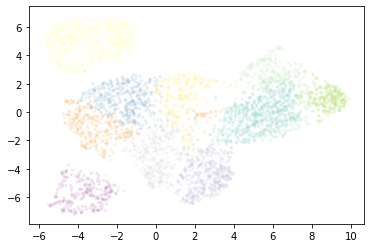

In [47]:
# vcy.scatter_viz(vlm.ts[:,0], vlm.ts[:,1], c=vlm.colorandum, s=2)
matplotlib.pyplot.scatter(vlm.embedding[:, 0],vlm.embedding[:, 1],c=louvain_colors,alpha=0.2,s=10,edgecolor="")
#matplotlib.pyplot.scatter(vlm.embedding[:, 0],vlm.embedding[:, 1],c="0.8",alpha=0.2,s=10,edgecolor="")

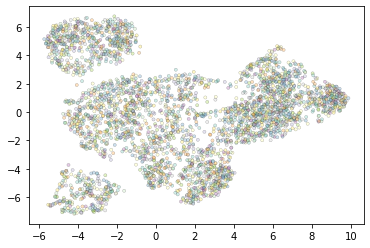

In [48]:
# overlay arrows
ix_choice = numpy.random.choice(vlm.embedding.shape[0], size=int(vlm.embedding.shape[0]/1.), replace=False)
matplotlib.pyplot.scatter(vlm.embedding[ix_choice, 0], vlm.embedding[ix_choice, 1],c=louvain_colors, alpha=0.4, s=10, edgecolor=(0,0,0,1), lw=0.3, rasterized=True)

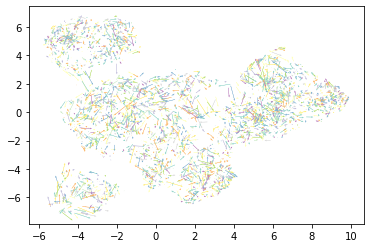

In [49]:
quiver_kwargs=dict(headaxislength=7, headlength=11, headwidth=8,linewidths=0.25, width=0.00045,edgecolors=louvain_colors, color=louvain_colors, alpha=1)
matplotlib.pyplot.quiver(vlm.embedding[ix_choice, 0], vlm.embedding[ix_choice, 1],vlm.delta_embedding[ix_choice, 0], vlm.delta_embedding[ix_choice, 1],**quiver_kwargs)

In [50]:
matplotlib.pyplot.savefig('figure2.pdf')
matplotlib.pyplot.clf()

<Figure size 432x288 with 0 Axes>

In [51]:
vlm.calculate_grid_arrows(smooth=0.8, steps=(40, 40), n_neighbors=nei)

86


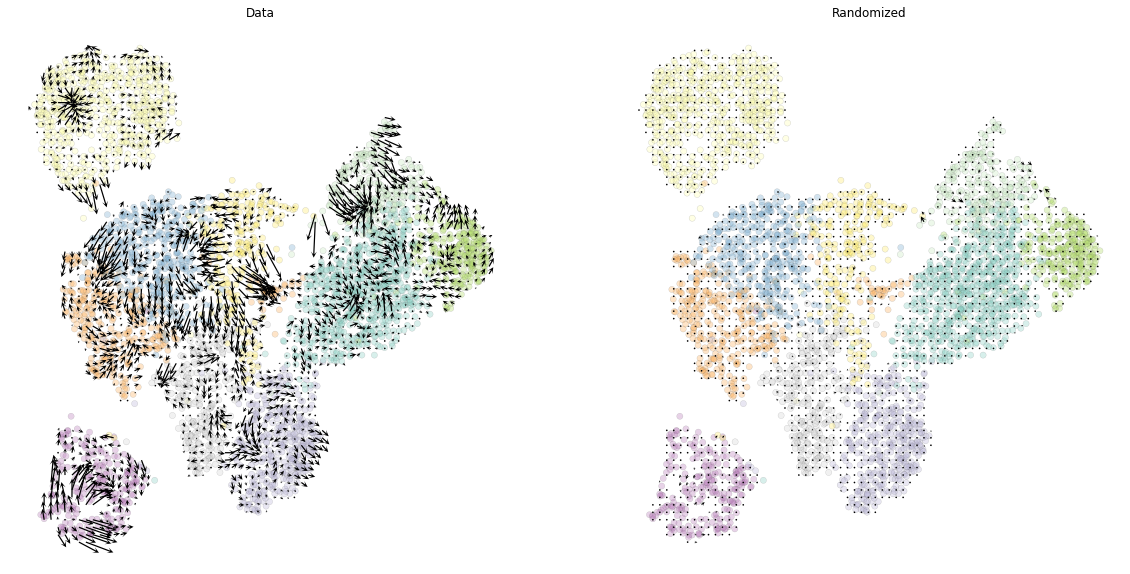

In [52]:
print(nei)
vlm.calculate_grid_arrows(smooth=0.85, steps=(70,70),n_neighbors=20)
matplotlib.pyplot.figure(None,(20,10))
vlm.colorandum=louvain_colors
vlm.plot_grid_arrows(quiver_scale='auto',scatter_kwargs_dict={"alpha":0.35, "lw":0.35, "edgecolor":"0.4", "s":38, "rasterized":True}, min_mass=5, angles='xy', scale_units='xy',headaxislength=2.75, headlength=5, headwidth=4.8, minlength=1.5,plot_random=True)